# WandB run data

In [1]:
import wandb
import os
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
fontsize = 12
plt.rc('font', size=fontsize)
plt.rc('axes', titlesize=fontsize)
plt.rcParams.update({'font.size': fontsize})

In [2]:
data_dir = "data"
run_prefix = 'wullli/flatland/'

In [3]:
#run_map = {"ApeX Rainbow-DQN TreeObs": ["10mbuqps", "8mbx883e"],
#           "ApeX DQN FTT": ["1xje7g7c", "3c8dz991"],
#           "ApeX DQN TreeObs": ["w3mw58ul", "3c8dz991"],
#           "PPO TreeObs and Action Masking": ["1fp8rsnd", "2cw55h5o"],
#           "Centralized Critic Transformer PPO TreeObs": ["3ohw0yo6", "14bkmmc1"],
#           "SAC TreeObs": ["2dj4pn4r", "3u3h718q", "3r7t8jn7"]}

In [4]:
run_map = {"RLPR-TCPR": ["2yio0wjn"]}

In [5]:
grouped_runs = {gn: [run_prefix + rid for rid in ids] for gn, ids in run_map.items()}

In [6]:
api = wandb.Api()

In [7]:
grouped_dfs = {}

for gn, run_paths in grouped_runs.items():
    dfs = []
    for i, run in enumerate(run_paths):
        run = api.run(run)
        data = run.history()
        dfs.append(data)
    grouped_dfs[gn] = dfs

In [8]:
def plot_with_error_band(x_key: str, y_key: str, 
                         dfs: list, 
                         color='#CC4F1B', 
                         offset=None,
                         label=None):
    lengths = [len(df.values) for df in dfs]
    min_len = min(lengths)
    xs = np.stack([df[x_key].values[:min_len] for df in dfs])
    ys = np.stack([df[y_key].values[:min_len] for df in dfs])
    
    min_y = np.min(ys, axis=0)
    max_y = np.max(ys, axis=0)
    mean_y = np.mean(ys, axis=0)
    mean_x = np.mean(xs, axis=0)

    plt.plot(mean_x, mean_y, 'k', color=color, label=label)
    plt.fill_between(mean_x, min_y, max_y,
        alpha=0.15, edgecolor=color, facecolor=color)

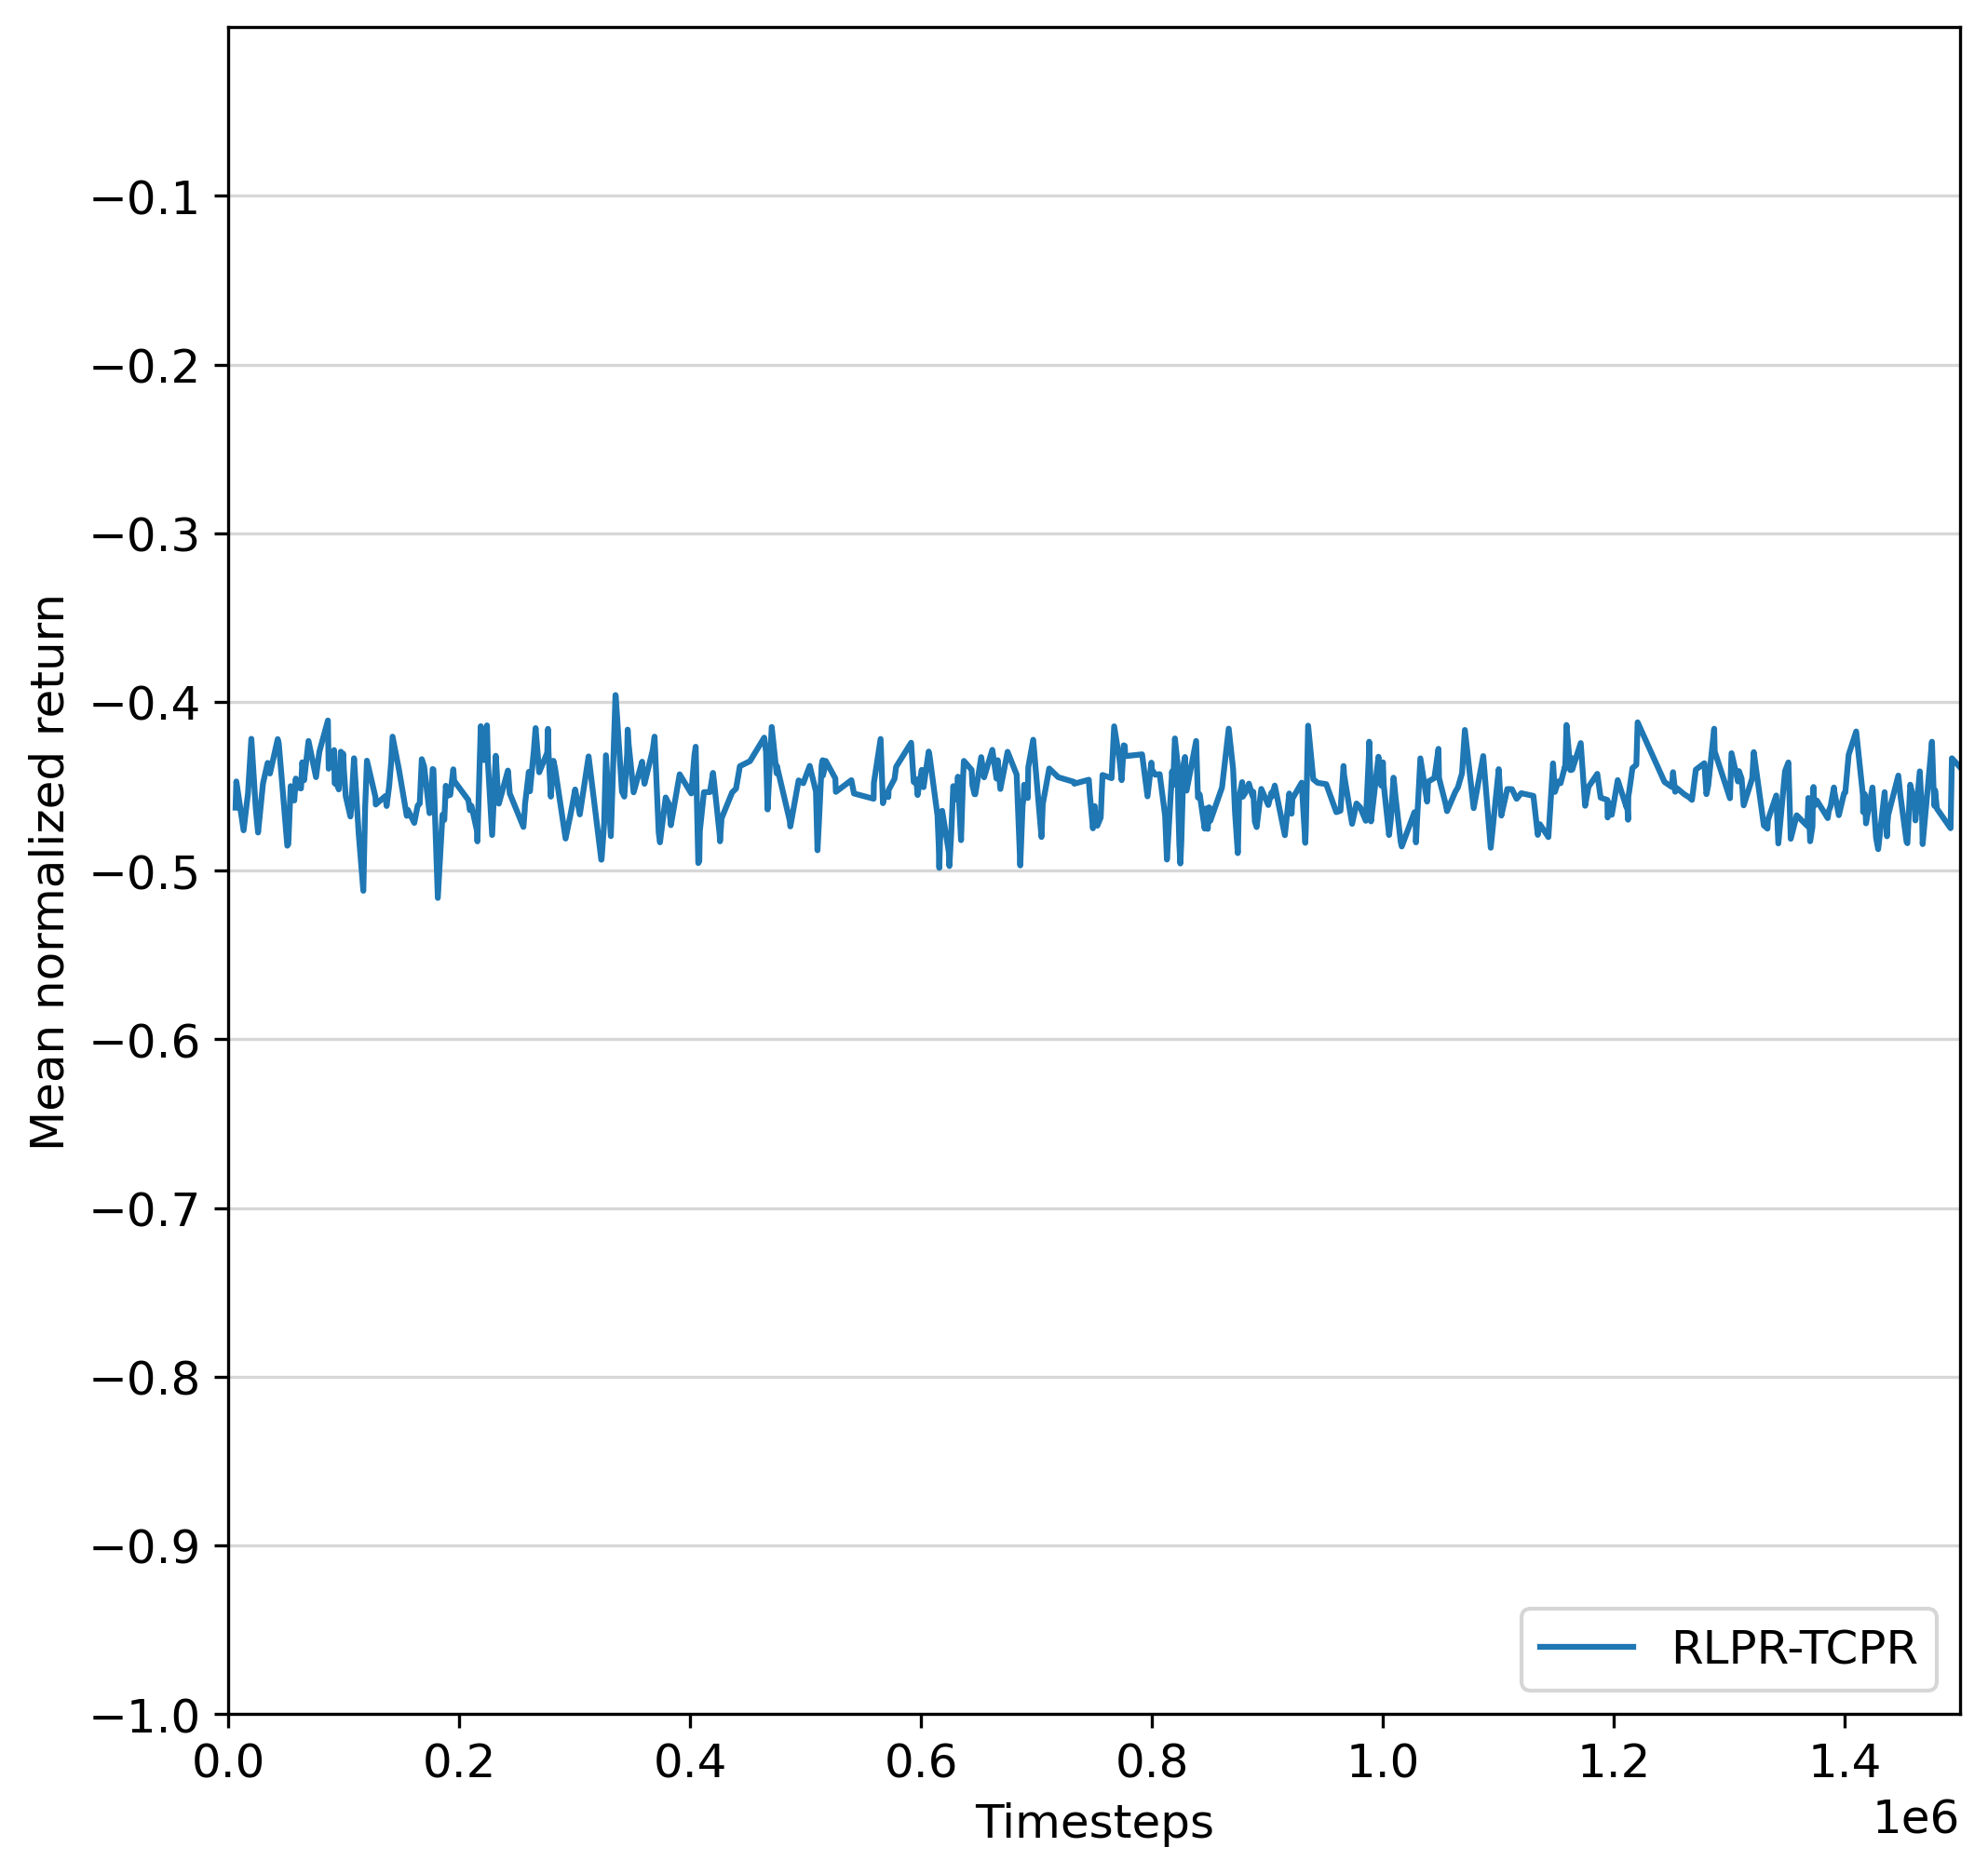

In [9]:
x_key = "timesteps_total"
y_key = "custom_metrics/episode_score_normalized_mean"

color_idx = 0
f = figure(num=None, figsize=(8, 8), dpi=300, facecolor='w', edgecolor='k')

plt.xlim((0, 1.5e6))
plt.ylim((-1, 0))

for gn, dfs in grouped_dfs.items():
    color = list(mcolors.TABLEAU_COLORS.values())[color_idx]
    plot_with_error_band(x_key, y_key, dfs, color, label=gn)
    color_idx += 1

plt.yticks(ticks=np.arange(-1, 0, 0.1))
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="lower right")
plt.ylabel("Mean normalized return")
plt.xlabel("Timesteps")
plt.title("")
plt.show()

f.savefig("./rlpr_returns.pdf", bbox_inches='tight')

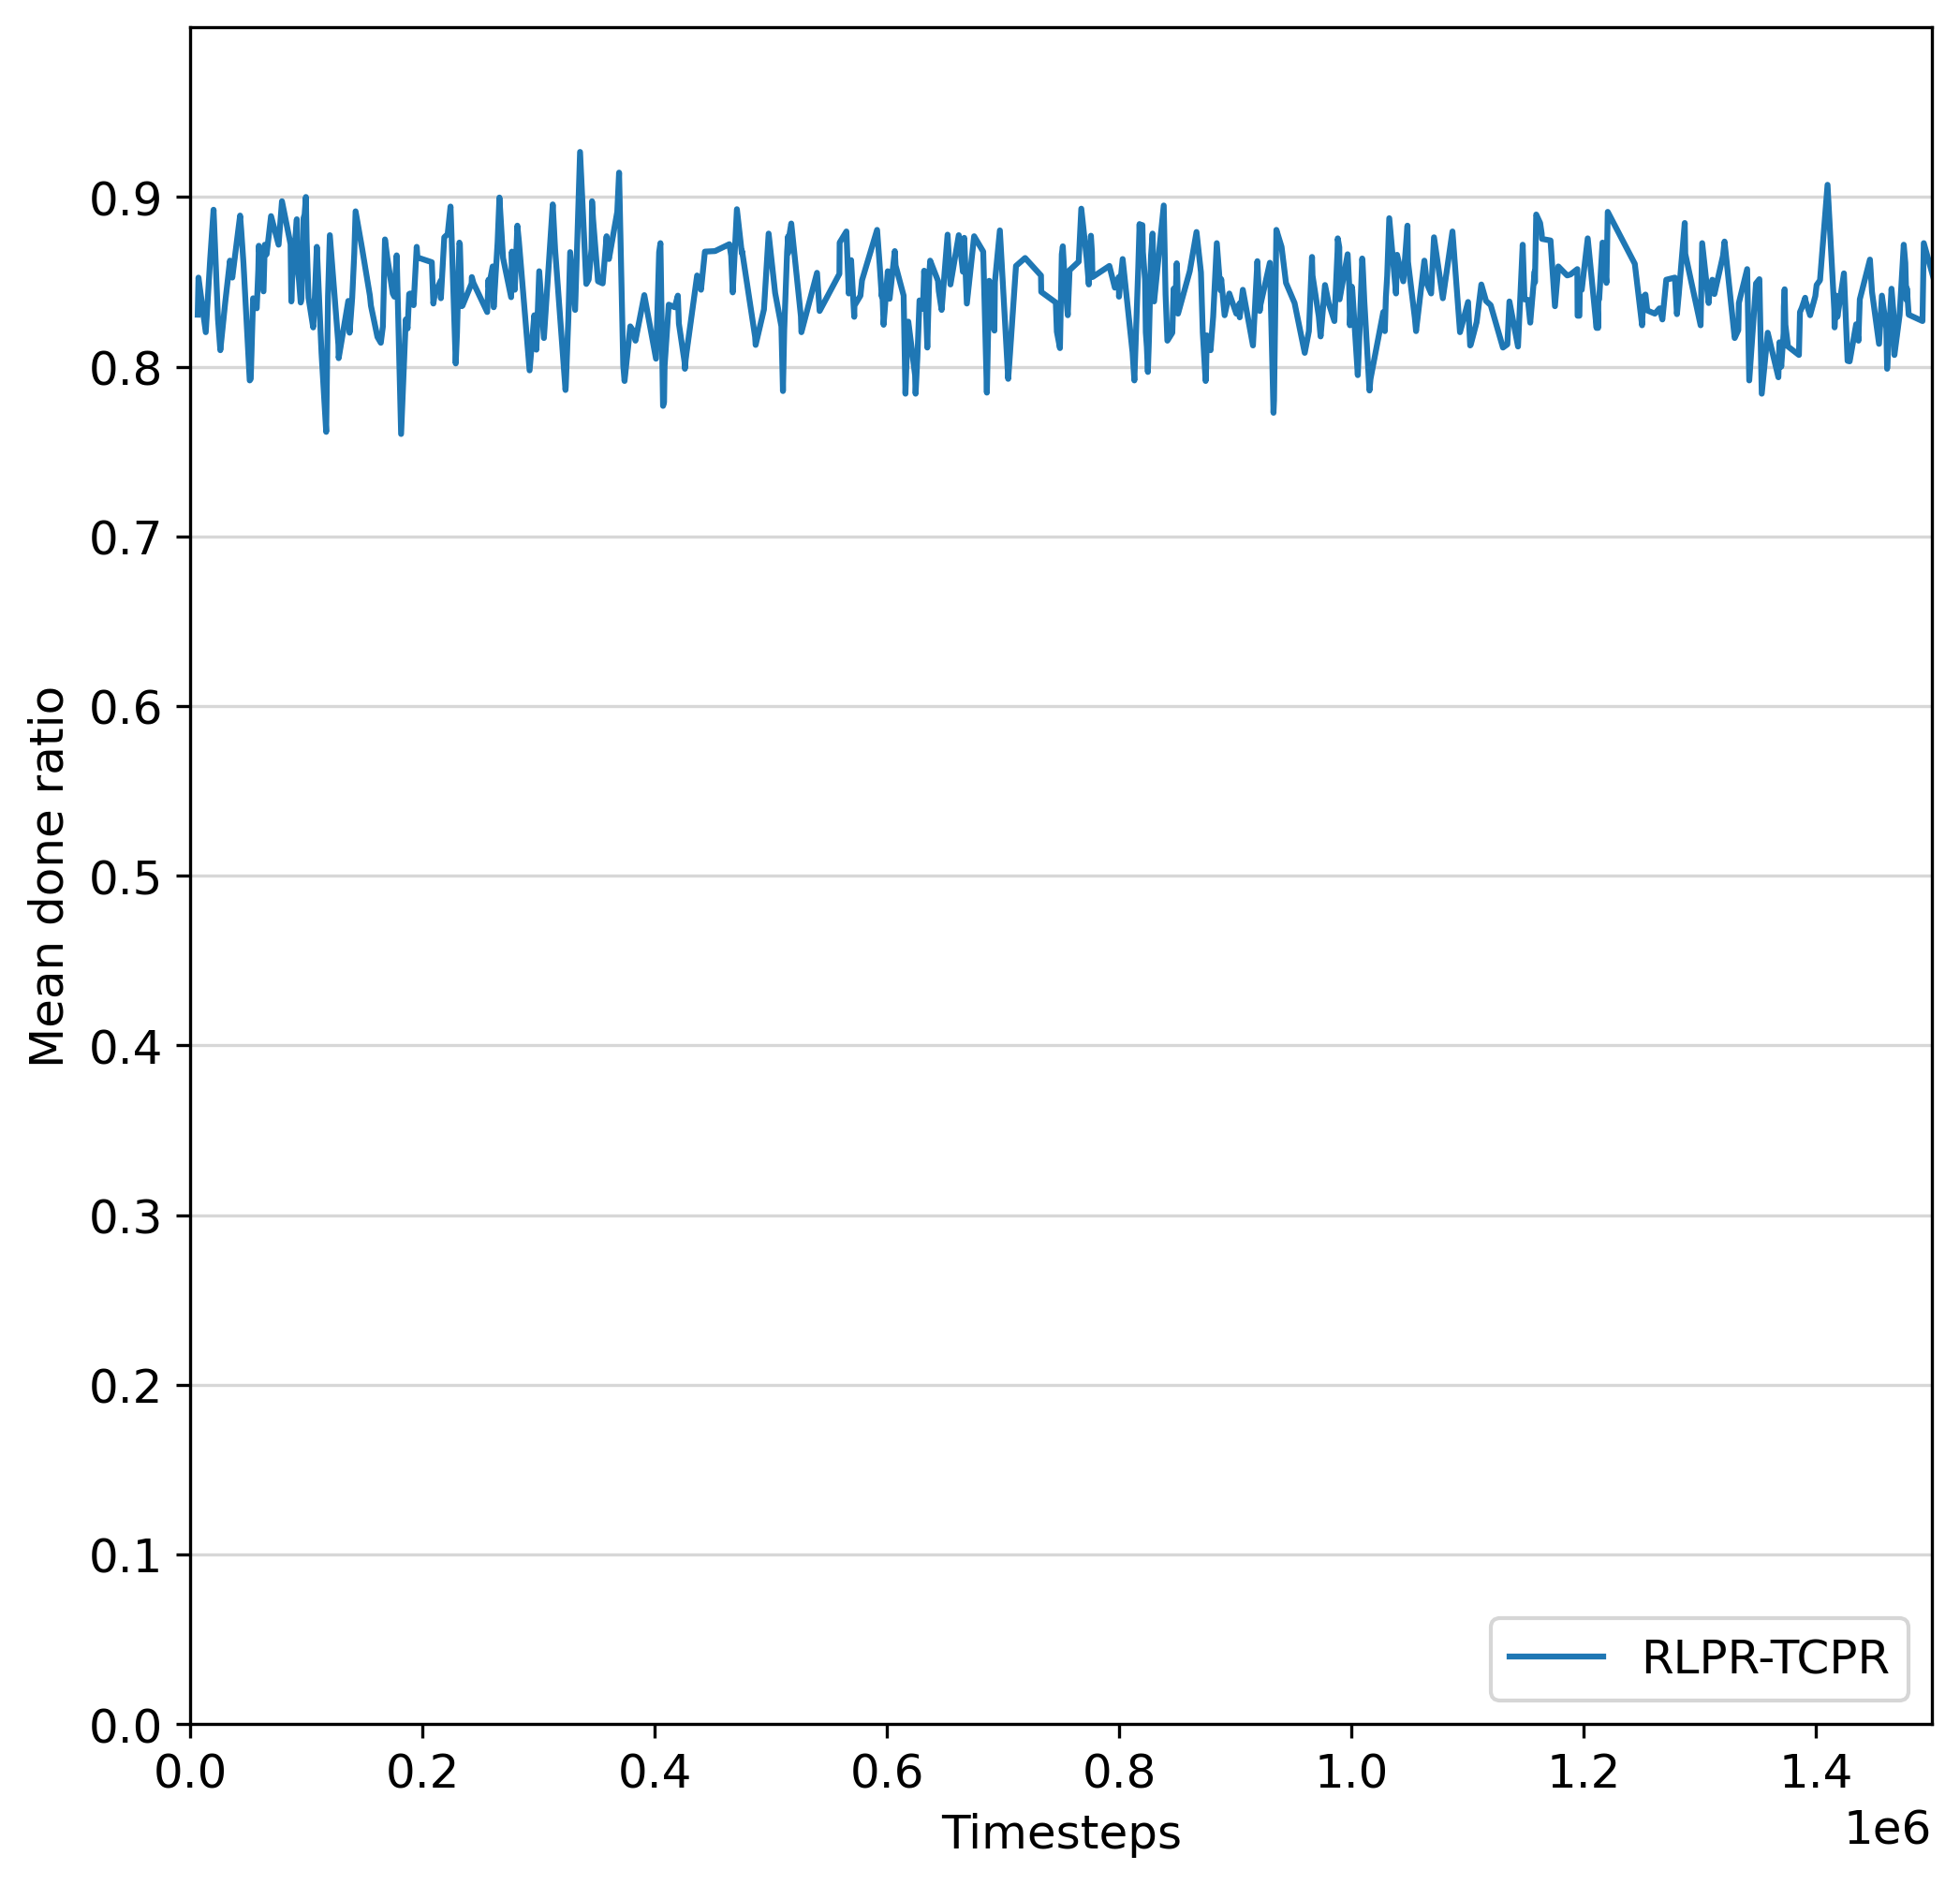

In [10]:
x_key = "timesteps_total"
y_key = "custom_metrics/percentage_complete_mean"

color_idx = 0
f = figure(num=None, figsize=(8, 8), dpi=300, facecolor='w', edgecolor='k')

plt.xlim((0, 1.5e6))
plt.ylim((0, 1))

for gn, dfs in grouped_dfs.items():
    color = list(mcolors.TABLEAU_COLORS.values())[color_idx]
    plot_with_error_band(x_key, y_key, dfs, color, label=gn)
    color_idx += 1

plt.yticks(ticks=np.arange(0, 1, 0.1))
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="lower right")
plt.ylabel("Mean done ratio")
plt.xlabel("Timesteps")
plt.title("")
plt.show()

f.savefig("./rlpr_doneratios.pdf", bbox_inches='tight')

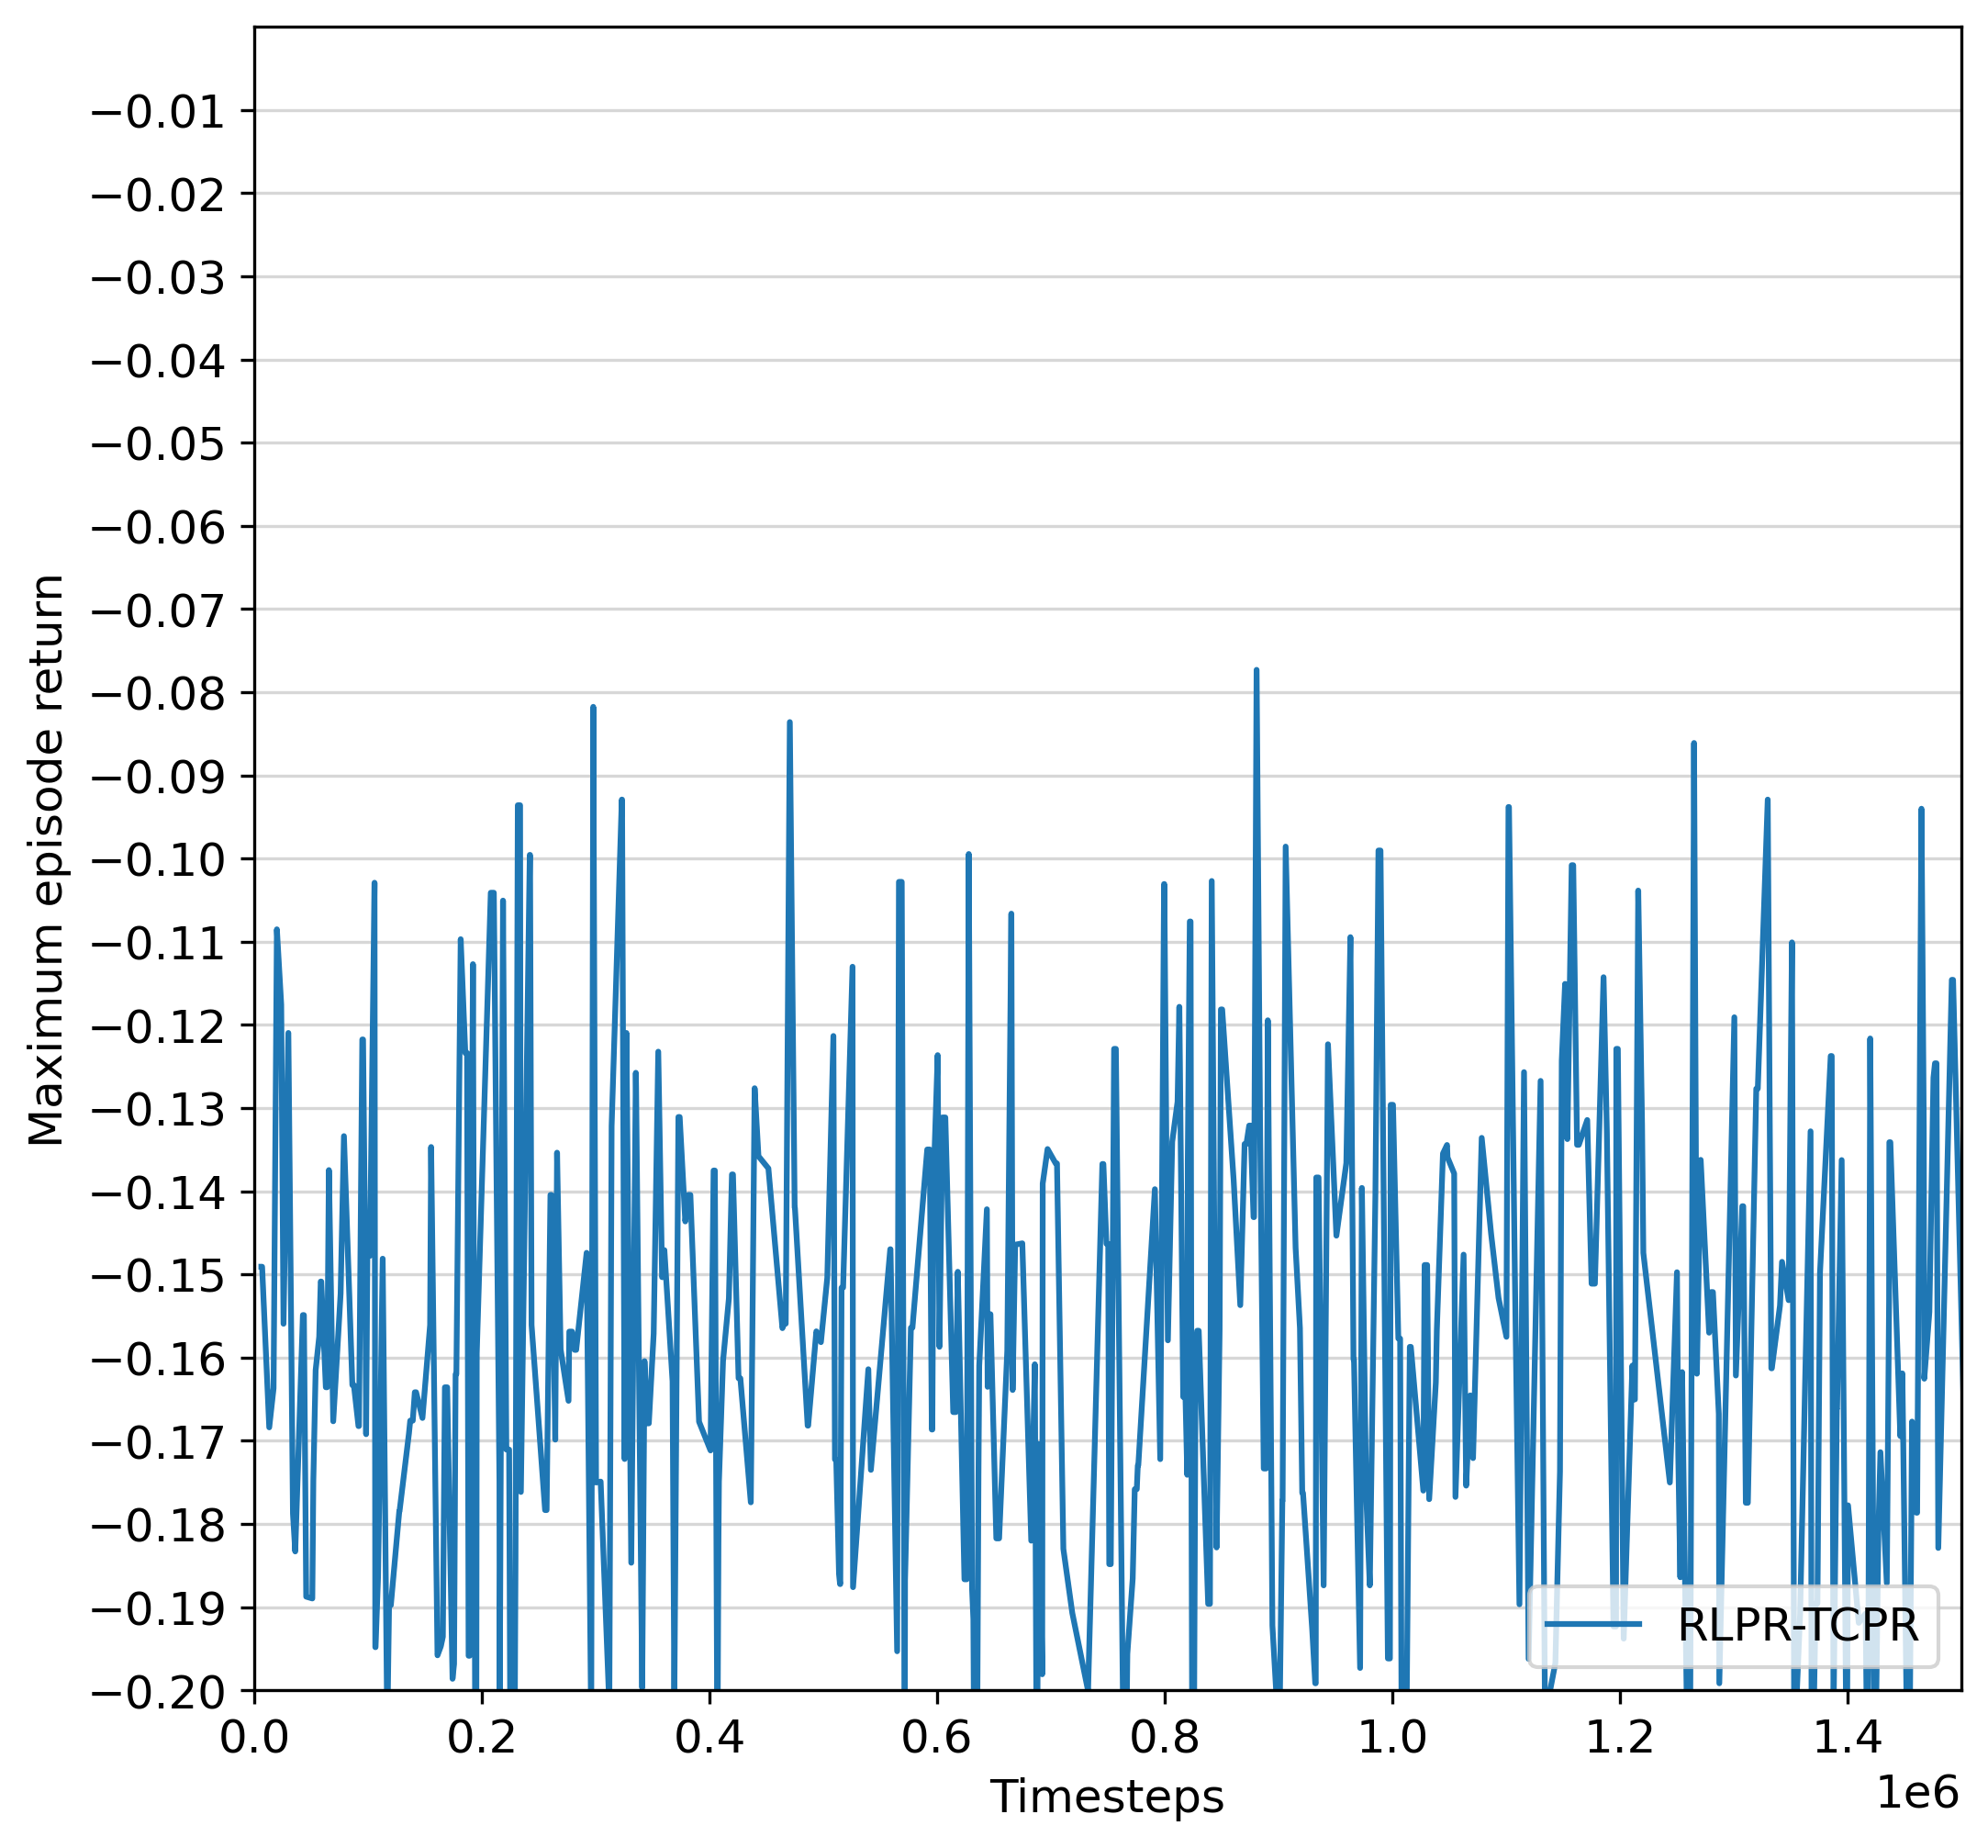

In [11]:
x_key = "timesteps_total"
y_key = "custom_metrics/episode_score_normalized_max"

color_idx = 0
f = figure(num=None, figsize=(8, 8), dpi=300, facecolor='w', edgecolor='k')

plt.xlim((0, 1.5e6))
plt.ylim((-0.2, 0))

for gn, dfs in grouped_dfs.items():
    color = list(mcolors.TABLEAU_COLORS.values())[color_idx]
    plot_with_error_band(x_key, y_key, dfs, color, label=gn)
    color_idx += 1

plt.yticks(ticks=np.arange(-0.2, 0, 0.01))
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="lower right")
plt.ylabel("Maximum episode return")
plt.xlabel("Timesteps")
plt.title("")
plt.show()

f.savefig("./rlpr_maxreturns.pdf", bbox_inches='tight')

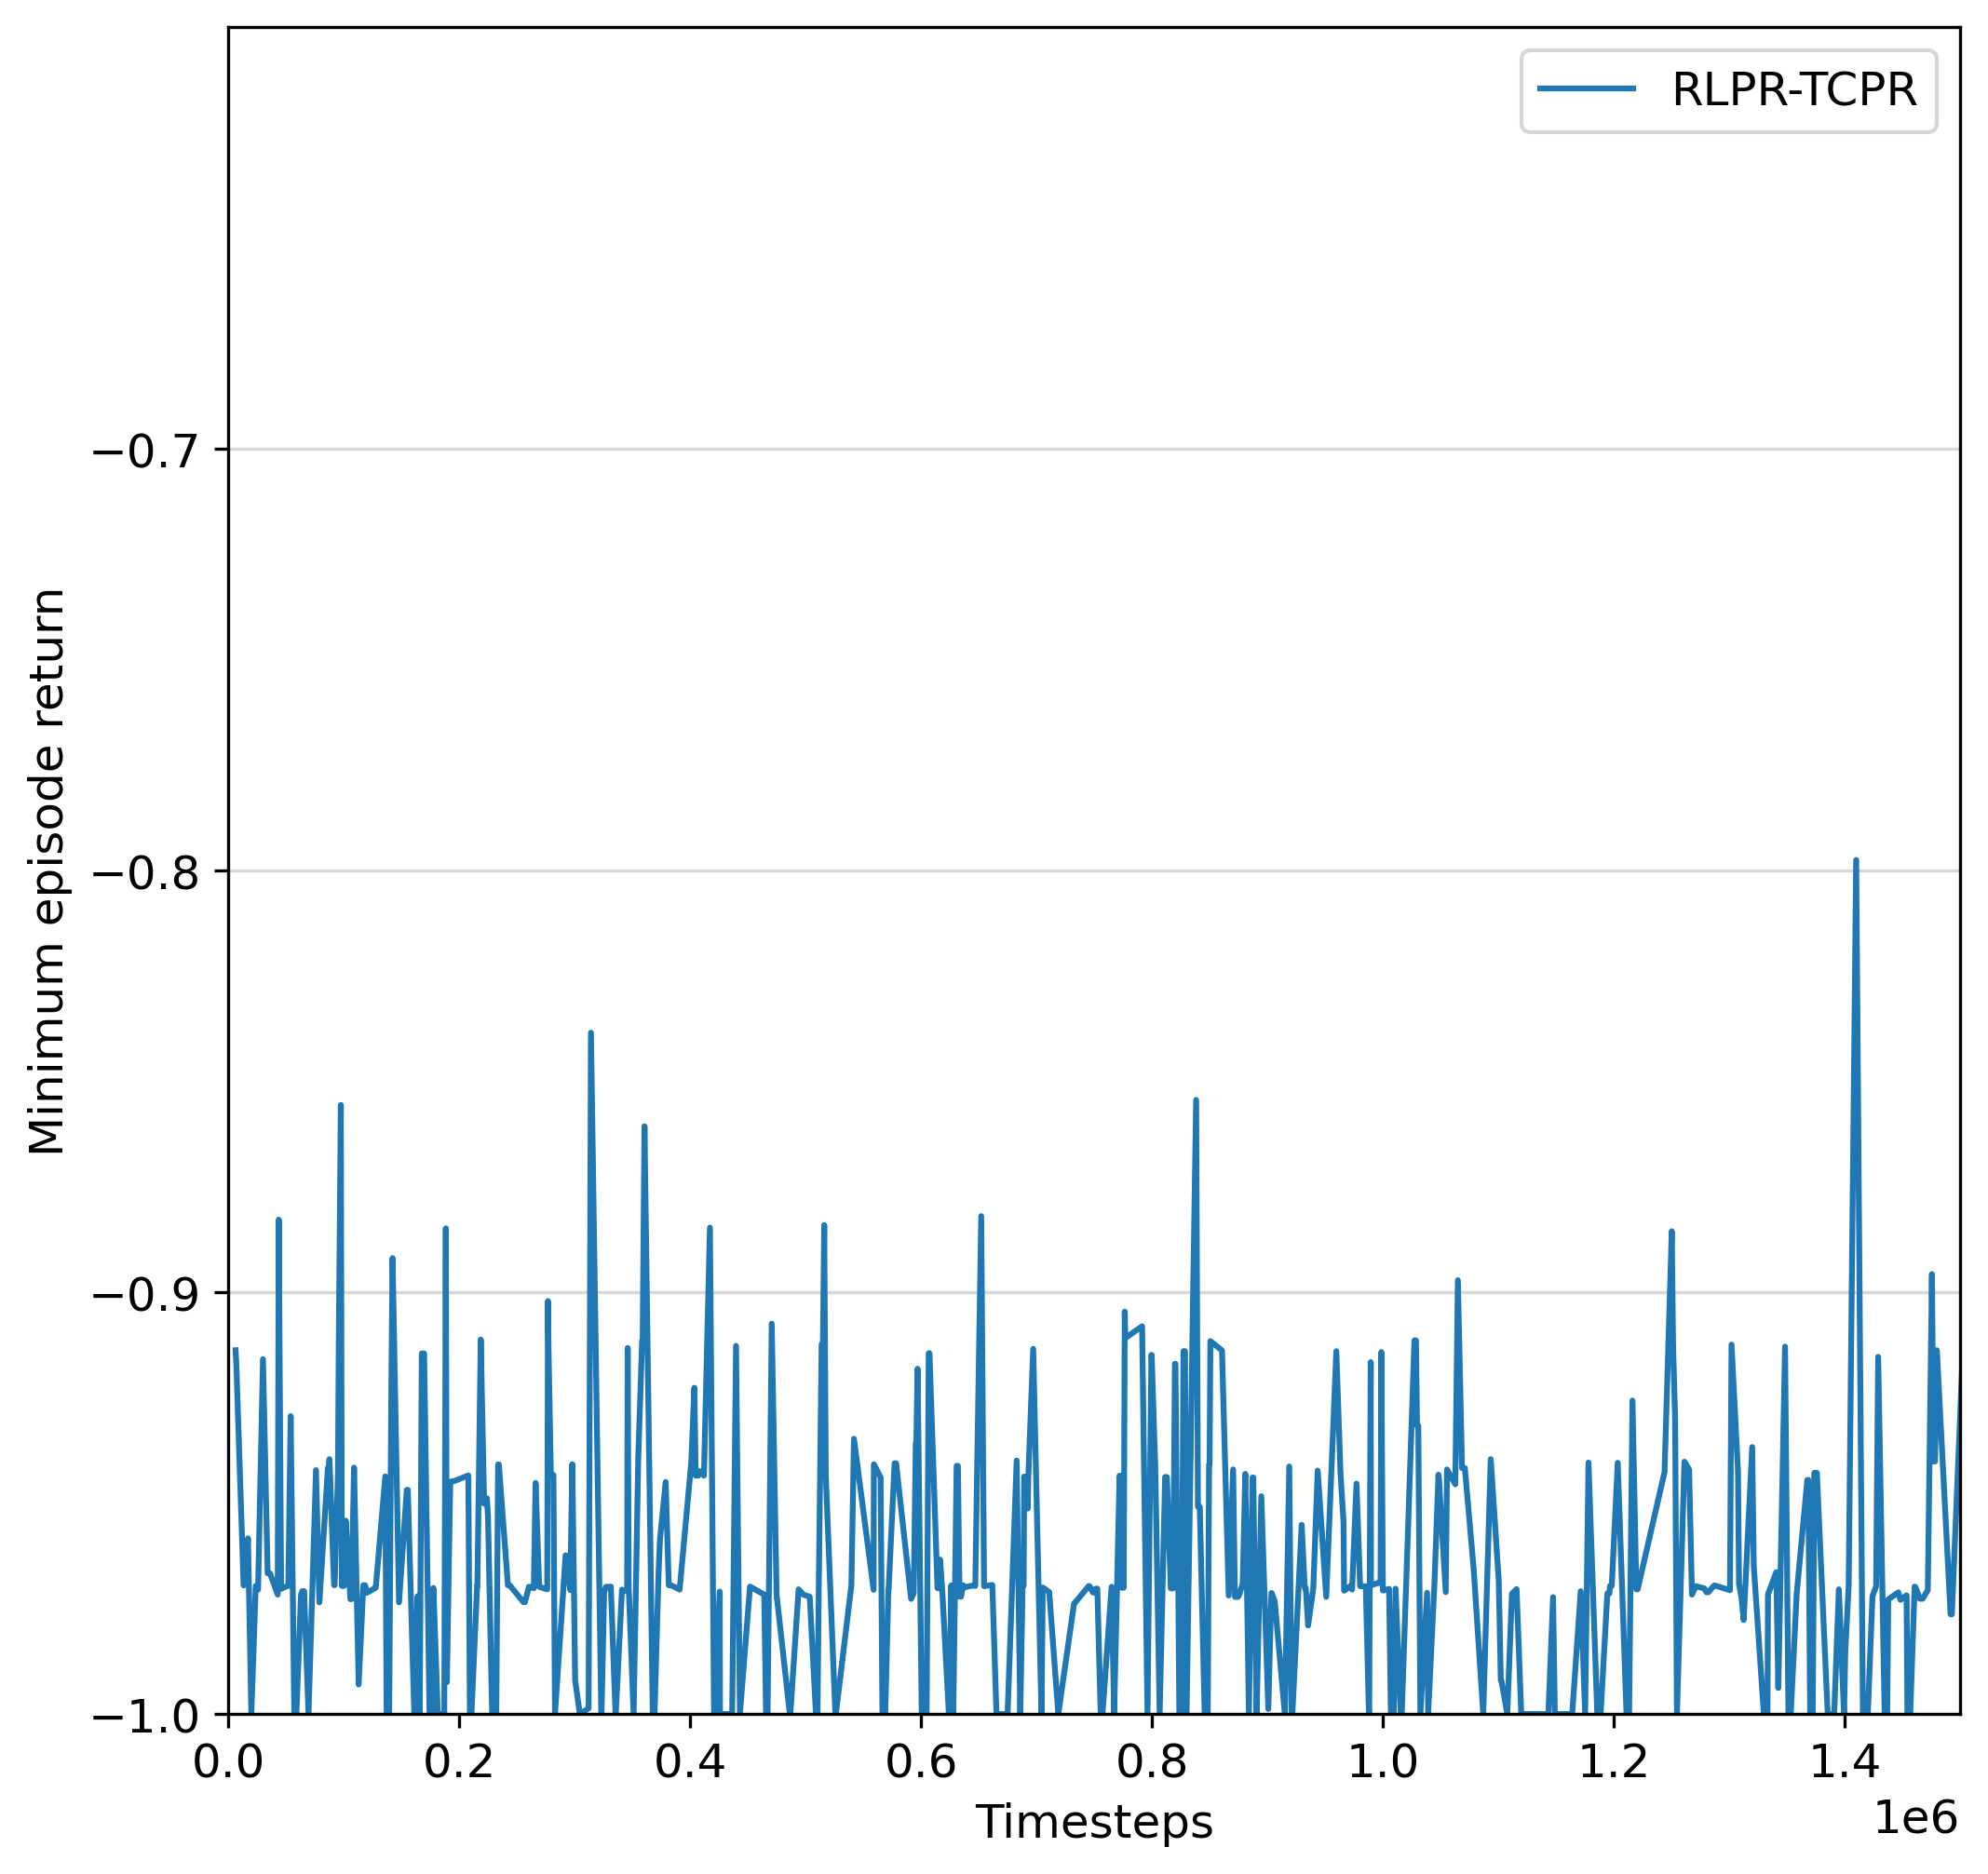

In [12]:
x_key = "timesteps_total"
y_key = "custom_metrics/episode_score_normalized_min"

color_idx = 0
f = figure(num=None, figsize=(8, 8), dpi=300, facecolor='w', edgecolor='k')

plt.xlim((0, 1.5e6))
plt.ylim((-1, -0.6))

for gn, dfs in grouped_dfs.items():
    color = list(mcolors.TABLEAU_COLORS.values())[color_idx]
    plot_with_error_band(x_key, y_key, dfs, color, label=gn)
    color_idx += 1

plt.yticks(ticks=np.arange(-1, -0.6, 0.1))
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="upper right")
plt.ylabel("Minimum episode return")
plt.xlabel("Timesteps")
plt.title("")
plt.show()

f.savefig("./rlpr_minreturns.pdf", bbox_inches='tight')